<a href="https://colab.research.google.com/github/bmreiniger/datascience.stackexchange/blob/master/SO55129963.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn==0.23

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

In [3]:
X_all, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
X_all.describe(include='all')

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
count,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,486,121.000000,745
unique,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3,27,NaN,369
top,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,13,NaN,"New York, NY"
freq,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,39,NaN,64
mean,2.294882,NaN,NaN,29.881135,0.498854,0.385027,NaN,33.295479,NaN,NaN,NaN,160.809917,NaN
std,0.837836,NaN,NaN,14.413500,1.041658,0.865560,NaN,51.758668,NaN,NaN,NaN,97.696922,NaN
min,1.000000,NaN,NaN,0.166700,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN,1.000000,NaN
25%,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN,72.000000,NaN
50%,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN,155.000000,NaN
75%,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,NaN,256.000000,NaN


# A simple case

In the original SO post, every variable was categorical and one-hot encoded for the model.  This is a bit easier to deal with, and has a slightly nicer syntax at the end, so let's tackle that first.

In [4]:
# To keep things simple for now, only use categoricals, so that we one-hot encode everything.
X = X_all[['pclass', 'sex', 'embarked']]

X['embarked'] = X['embarked'].fillna('S')

ohe = OneHotEncoder()
X_enc = ohe.fit_transform(X)

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X_enc, y);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


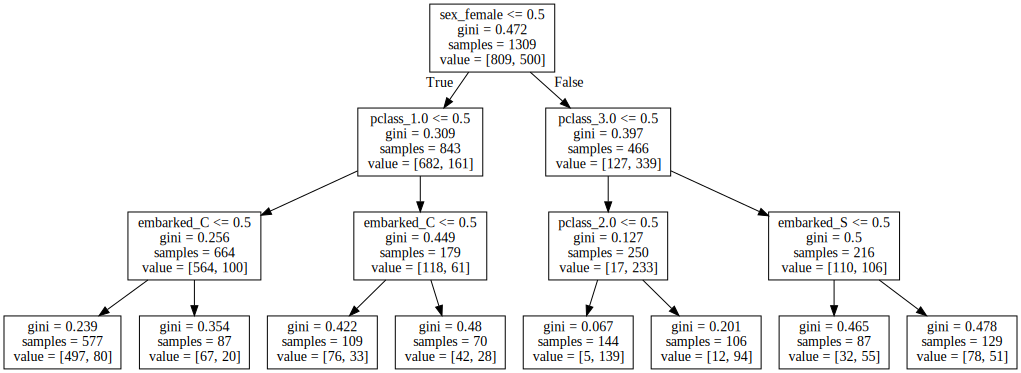

In [5]:
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=ohe.get_feature_names(input_features=X.columns)
)
graph = graphviz.Source(dot_data)
graph.render("tree_plot")
graph

In [6]:
print(dot_data)

digraph Tree {
node [shape=box] ;
0 [label="sex_female <= 0.5\ngini = 0.472\nsamples = 1309\nvalue = [809, 500]"] ;
1 [label="pclass_1.0 <= 0.5\ngini = 0.309\nsamples = 843\nvalue = [682, 161]"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="embarked_C <= 0.5\ngini = 0.256\nsamples = 664\nvalue = [564, 100]"] ;
1 -> 2 ;
3 [label="gini = 0.239\nsamples = 577\nvalue = [497, 80]"] ;
2 -> 3 ;
4 [label="gini = 0.354\nsamples = 87\nvalue = [67, 20]"] ;
2 -> 4 ;
5 [label="embarked_C <= 0.5\ngini = 0.449\nsamples = 179\nvalue = [118, 61]"] ;
1 -> 5 ;
6 [label="gini = 0.422\nsamples = 109\nvalue = [76, 33]"] ;
5 -> 6 ;
7 [label="gini = 0.48\nsamples = 70\nvalue = [42, 28]"] ;
5 -> 7 ;
8 [label="pclass_3.0 <= 0.5\ngini = 0.397\nsamples = 466\nvalue = [127, 339]"] ;
0 -> 8 [labeldistance=2.5, labelangle=-45, headlabel="False"] ;
9 [label="pclass_2.0 <= 0.5\ngini = 0.127\nsamples = 250\nvalue = [17, 233]"] ;
8 -> 9 ;
10 [label="gini = 0.067\nsamples = 144\nvalue = [5, 13

In [7]:
list(zip(X.columns, ohe.categories_))

[('pclass', array([1., 2., 3.])),
 ('sex', array(['female', 'male'], dtype=object)),
 ('embarked', array(['C', 'Q', 'S'], dtype=object))]

In this very simple situation where every feature is a dummy variable, every split is of the form `{feature}_{level} <= 0.5` with `True` going left.  That's equivalent to the original `feature` _not_ taking value `level`, so we'll write `feature=level`, and swap the branches to left being `False` and right `True`.

In [8]:
import re
new_dot = dot_data
for i, col in enumerate(X.columns):
  for cat in ohe.categories_[i]:
    new_dot = re.sub(f"{col}_{cat} <= 0.5", f"{col}={cat}", new_dot)

new_dot = re.sub('labelangle=45, headlabel="True"', 'labelangle=45, headlabel="False"', new_dot)
new_dot = re.sub('labelangle=-45, headlabel="False"', 'labelangle=-45, headlabel="True"', new_dot)


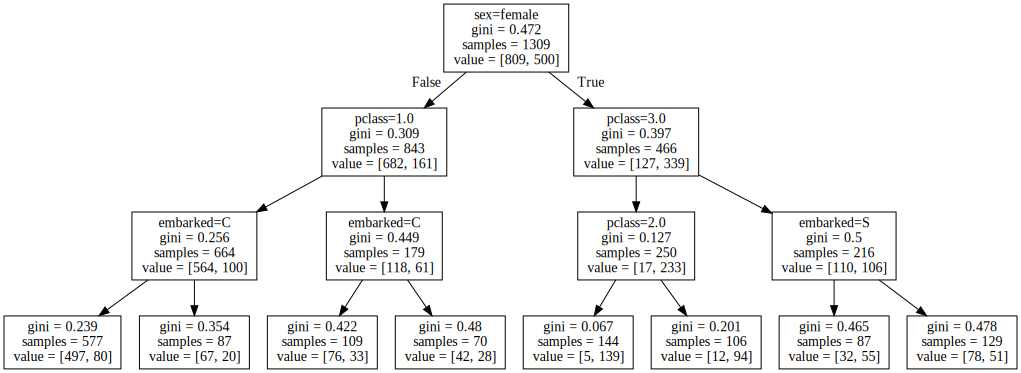

In [9]:
graph = graphviz.Source(new_dot)
graph.render("tree_plot")
graph

# A more general case

We can still do this with a `ColumnTransformer` only encoding some variables.  The `get_feature_names` method still hasn't made its way to `Pipeline`s or a number of transformers, so we can't get too carried away without going way off topic.  And I don't want to try to hack up the branch labels too much, so we'll use the somewhat less pleasing split phrase `feature!=level` (so that `True` can still go left).

In [10]:
from sklearn.compose import ColumnTransformer

cat_cols = ['pclass', 'sex', 'embarked']
num_cols = ['age', 'sibsp', 'parch', 'fare', 'body']
X = X_all[[col for col in cat_cols + num_cols]]

# pclass is encoded as floats, but we want the column_selector to treat them as categories
X.loc[:, 'pclass'] = X['pclass'].astype(str)
X.loc[:, 'embarked'] = X['embarked'].fillna('S')

X.loc[:, num_cols] = X[num_cols].fillna(X[num_cols].median())

preproc = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_cols),
    ],
    remainder='passthrough',
)

preproc.fit(X);

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(preproc.fit_transform(X), y);

In [12]:
preproc.named_transformers_['cat'].categories_

[array(['1.0', '2.0', '3.0'], dtype=object),
 array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S'], dtype=object)]

In [13]:
# Ugh, these almost-working `get_feature_names` are getting hairy.
# OHE needs the input names, but columntransformer doesn't let you pass those through.
# I guess we're going to do this more manually than I'd like.

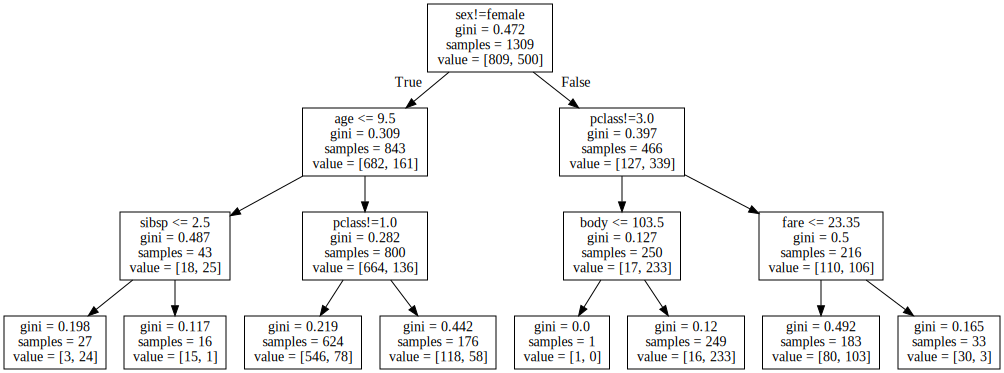

In [14]:
dot_data = export_graphviz(
    clf,
    out_file=None,
    feature_names=list(preproc.named_transformers_['cat'].get_feature_names(cat_cols)) + num_cols
)

new_dot = dot_data
for i, col in enumerate(cat_cols):
    for cat in preproc.named_transformers_['cat'].categories_[i]:
        new_dot = re.sub(f"{col}_{cat} <= 0.5", f"{col}!={cat}", new_dot)

graph = graphviz.Source(new_dot)
graph.render("tree_plot")
graph
